{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Create a cumulative sum plot in **Pandas** to better understand stream discharge in a watershed.

</div>

## Introduction to Flood Frequency Analysis

To begin, load all of your libraries.

# docs for this api!
https://pypi.org/project/HydroFunctions/


http://earthpy.org/flow.html

In [1]:
import os
import urllib
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import earthpy as et
import hydrofunctions as hf

# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get the data & set working director
data = et.data.get_data('colorado-flood')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Trying to remove warning and get plots to render
%matplotlib inline

# UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path() 

## Download Stream Gage Data

Picking up from the previous lesson... 

In [3]:
# Define the site number and start and end dates that you are interested in
site = "06730500"
start = '1946-05-10'
end = '2018-08-29'

# Request data for that site and time period
longmont_resp = hf.get_nwis(site, 'dv', start, end)

# Convert the response to a json in order to use the extract_nwis_df function
longmont_resp = longmont_resp.json()

# Get metadata about the data
hf.get_nwis(site, 'dv').json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/dv/format=json%2C1.1&sites=06730500&parameterCd=00060',
   'criteria': {'locationParam': '[ALL:06730500]',
    'variableParam': '[00060]',
    'parameter': []},
   'note': [{'value': '[ALL:06730500]', 'title': 'filter:sites'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2020-03-02T23:32:28.523Z', 'title': 'requestDT'},
    {'value': '1488b4a0-5cde-11ea-acf4-6cae8b663fb6', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'vaas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': '

In [4]:
# Get the data in a pandas dataframe format
longmont_discharge = hf.extract_nwis_df(longmont_resp)

# Rename columns
longmont_discharge.columns = ["discharge", "flag"]

# Add a year column to your longmont discharge data
longmont_discharge["year"] = longmont_discharge.index.year

# Calculate annual max by resampling
longmont_discharge_annual_max = longmont_discharge.resample('AS').max()

# View first 5 rows
longmont_discharge_annual_max.head()

,discharge,flag,year
datetime,,,
1946-01-01,99.0,A,1946.0
1947-01-01,1930.0,A,1947.0
1948-01-01,339.0,A,1948.0
1949-01-01,2010.0,A,1949.0
1950-01-01,NaN,NaN,NaN


In [5]:
# Download usgs annual max data from figshare
url = "https://nwis.waterdata.usgs.gov/nwis/peak?site_no=06730500&agency_cd=USGS&format=rdb"

download_path = os.path.join("data", "colorado-flood", 
                             "downloads", "annual-peak-flow.txt")

urllib.request.urlretrieve(url, download_path)

# Open the data using pandas
usgs_annual_max = pd.read_csv(download_path,
                              comment="#",
                              sep='\t',
                              parse_dates=["peak_dt"],
                              skiprows=[73],
                              usecols=["peak_dt","peak_va"],
                              index_col="peak_dt")
usgs_annual_max.head()

# Add a year column to the data for easier plotting
usgs_annual_max["year"] = usgs_annual_max.index.year

# Remove duplicate years - keep the max discharge value
usgs_annual_max = usgs_annual_max.sort_values(
    'peak_va', ascending=False).drop_duplicates('year').sort_index()

# View cleaned dataframe
usgs_annual_max.head()

,peak_va,year
peak_dt,,
1927-07-29,407.0,1927
1928-06-04,694.0,1928
1929-07-23,530.0,1929
1930-08-18,353.0,1930
1931-05-29,369.0,1931


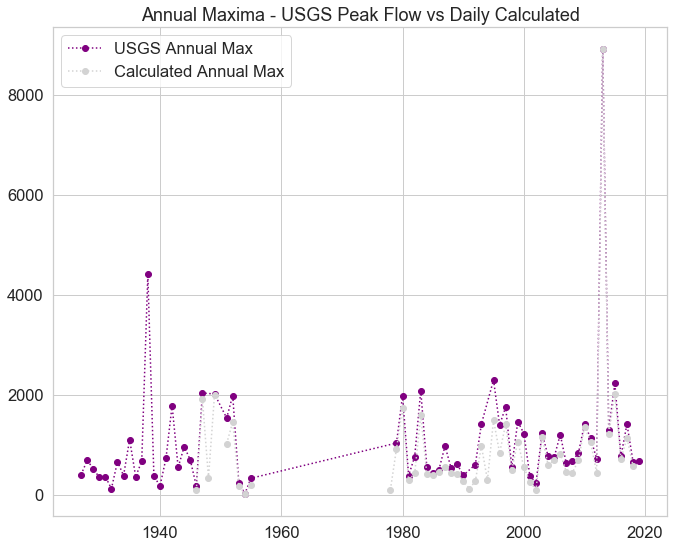

In [6]:
# Plot calculated vs USGS annual max flow values
fig, ax = plt.subplots(figsize = (11,9))

ax.plot(usgs_annual_max["year"], 
        usgs_annual_max["peak_va"],
        color = "purple",
        linestyle=':', 
        marker='o', 
        label = "USGS Annual Max")

ax.plot(longmont_discharge_annual_max["year"], 
        longmont_discharge_annual_max["discharge"],
        color = "lightgrey",
        linestyle=':', 
        marker='o', label = "Calculated Annual Max")

ax.legend()
ax.set_title("Annual Maxima - USGS Peak Flow vs Daily Calculated")

plt.show()

## Calculate Cumulative Sum

Next you will create a plot that shows both stream discharge the the total cumulative runnof that it represents over the time period of interest. This plot is useful as you will be able to compare this to a plot of precipitation that you create for your homework. 

Together - stream runoff and precipitation can be explored to better understand the mass balance of water in your watershed of interest. The total precipitation in the watershed minus the total runoff can be used to calculate how much water is being "lost" in the system to evapotranspiration. The steps are as follows:

1. Calculate the cumulative sum using the `.cumsum()` method in pandas.
2. Convert CFS (Cubic Feet per Second) to a more meaningful unit of runoff by
    * converting CFS to Cubic feet per day
    * divide this value by the total area in the watershed to get a volume of water per area

<a href="https://waterdata.usgs.gov/nwis/inventory/?site_no=06730500" target = "_blank">USGS Site page</a> has the area of the site drainage area: 447 square miles

In [7]:
# Convert site drainage area to square km
miles_km = 2.58999
site_drainage = 447
longmont_area = site_drainage * miles_km

print("The site drainage area in square km =", longmont_area)

The site drainage area in square km = 1157.72553


Next you calculate the cumulative sum, convert that to cubic feet per day and then divide by the drainage area.


In [8]:
convert_to_cub_feet_day = (60*60*24)

convert_to_runoff = convert_to_cub_feet_day*longmont_area
convert_to_runoff

100027485.792

In [9]:
# MAR - Mean Annual Runoff
longmont_discharge["cum-sum-vol"] = longmont_discharge[
    'discharge'].cumsum()*convert_to_runoff

longmont_discharge.head()

,discharge,flag,year,cum-sum-vol
datetime,,,,
1946-05-10,16.0,A,1946,1.600440e+09
1946-05-11,19.0,A,1946,3.500962e+09
1946-05-12,9.0,A,1946,4.401209e+09
1946-05-13,3.0,A,1946,4.701292e+09
1946-05-14,7.8,A,1946,5.481506e+09


## Plot Cumulative Sum of Runnof and Daily Mean Discharge Together

Finally you can plot cumulative sum on top of your discharge values. This plot is an interesting way to to view increases and decreases in discharge as they occur over time.

### Creating this Plot
Notice below you have two sets of data with different Y axes on the same plot. The key to making this work is 
this:

`ax2 = ax.twinx()`

Where you define a second axis but tell matplotlib to create that axis on the `ax` object in your figure.

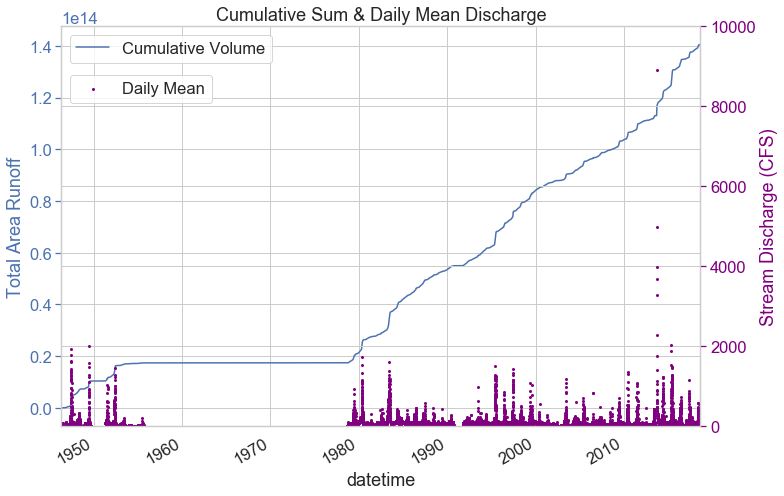

In [10]:
# Plot your data
fig, ax = plt.subplots(figsize=(11,7))
longmont_discharge["cum-sum-vol"].plot(ax=ax, label = "Cumulative Volume")

# Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('Total Area Runoff', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()

ax2.scatter(x=longmont_discharge.index, 
        y=longmont_discharge["discharge"], 
        marker="o",
        s=4, 
        color ="purple", label="Daily Mean")

ax2.set_ylabel('Stream Discharge (CFS)', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_ylim(0,10000)

ax.set_title("Cumulative Sum & Daily Mean Discharge")
ax.legend()

# Reposition the second legend so it renders under the first legend item
ax2.legend(loc = "upper left", bbox_to_anchor=(0.0, 0.9))

fig.tight_layout()

plt.show()